In [49]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.ticker as ticker
import plotly.io as pio
from sklearn.cluster import KMeans
from mlxtend.frequent_patterns import apriori, association_rules

%matplotlib inline

In [32]:
# Load Dataset

abs_path = Path.cwd()
data_address = abs_path.parent.parent / 'data/' / 'Cleaned_US.csv'
df = pd.read_csv(data_address)

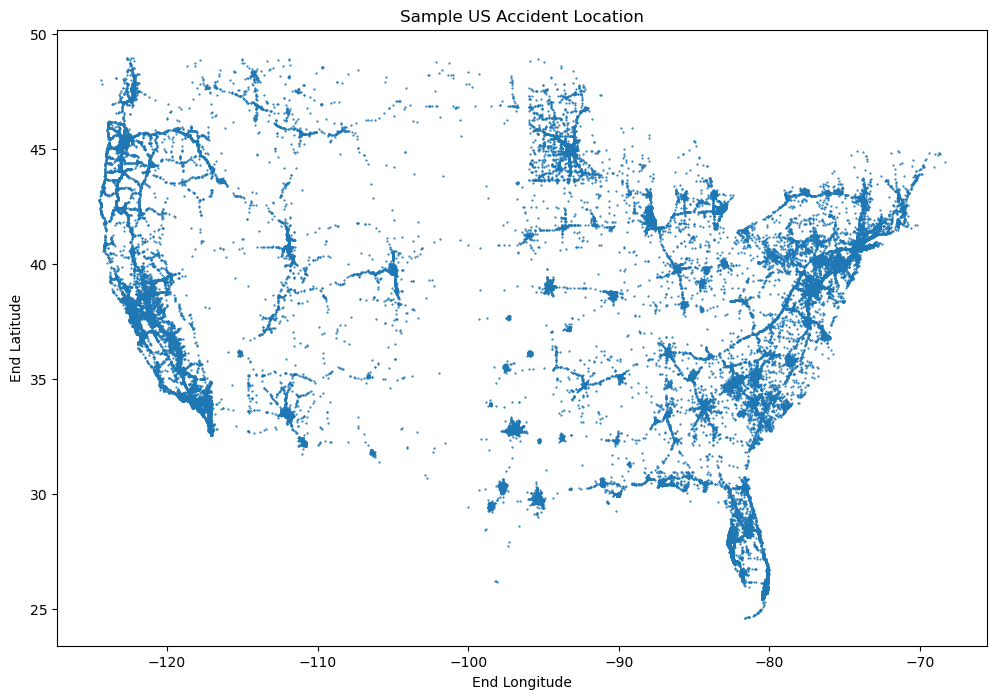

In [33]:
sample_size = 100000
sample_df = df.sample( n = sample_size, random_state = 42 )

plt.figure(figsize=(12, 8))
plt.scatter( sample_df['End_Lng'], sample_df['End_Lat'], s=0.3 )
plt.xlabel('End Longitude')
plt.ylabel('End Latitude')
plt.title('Sample US Accident Location')

plt.show()

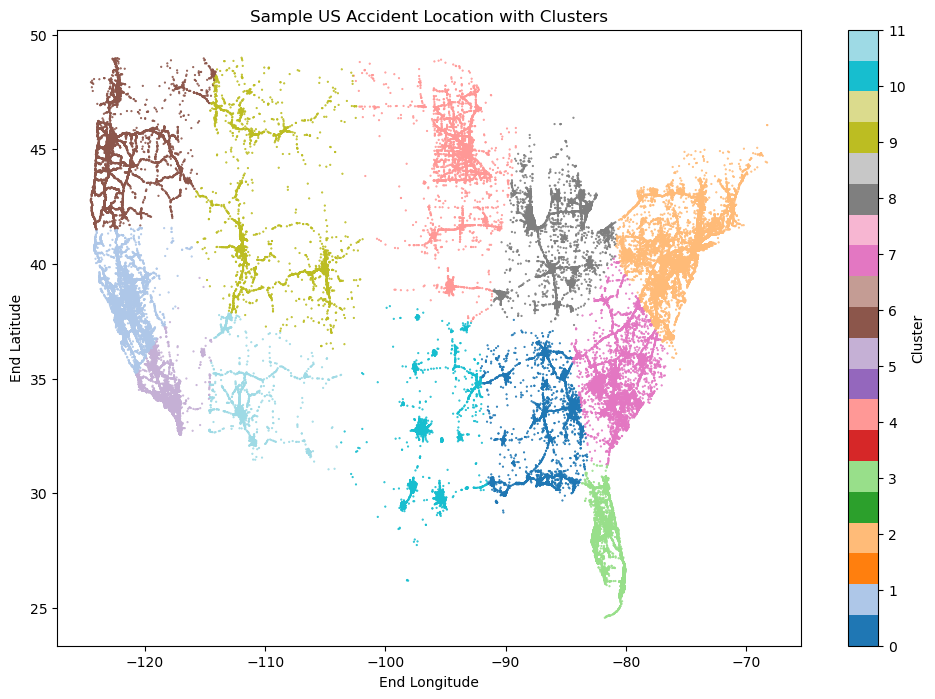

In [85]:
sample_size = 200000
sample_df = df.sample(n=sample_size, random_state=42)

# Clustering
X = sample_df[['End_Lng', 'End_Lat']]
kmeans = KMeans(n_clusters=12, random_state=42)
sample_df['Cluster'] = kmeans.fit_predict(X)

# Plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(sample_df['End_Lng'], sample_df['End_Lat'], c=sample_df['Cluster'], cmap='tab20', s=0.3)
plt.xlabel('End Longitude')
plt.ylabel('End Latitude')
plt.title('Sample US Accident Location with Clusters')

# Add colorbar
cbar = plt.colorbar(scatter, ticks=range(12))
cbar.set_label('Cluster')

plt.show()


In [86]:
# Create a dict to store the dataframes for each cluster
cluster_data = {}

# Iterate over unique cluster labels
for cluster_label in sample_df['Cluster'].unique():
    # Filter the dataframe based on the cluster label
    cluster_data[cluster_label] = sample_df[sample_df['Cluster'] == cluster_label].copy()
    

In [91]:
def dynamic_convertor(df):
    # Define weather float columns
    weather_float_columns = ['Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)']

    # Create a new DataFrame for encoded columns
    df_dynamic_threshold = pd.DataFrame()

    # Discretize and encode weather columns using one-hot encoding
    for column in weather_float_columns:
        column_values = df[column]
        
        # Adjust threshold percentages if they are the same
        if len(set(column_values)) == 1:
            min_value = column_values.min()
            max_value = column_values.max()
            if min_value == max_value:
                thresholds = [0, min_value, min_value + 1, float('inf')]
            else:
                thresholds = [0, min_value, max_value, float('inf')]
        else:
            thresholds = [0, np.percentile(column_values, 15), np.percentile(column_values, 85), float('inf')]
        
        bins = np.unique(thresholds)  # Ensure unique bin edges
        labels = range(len(bins) - 1)
        categories = pd.cut(column_values, bins=bins, labels=labels)
        encoded_cols = pd.get_dummies(categories, prefix=column)
        df_dynamic_threshold = pd.concat([df_dynamic_threshold, encoded_cols], axis=1)

    return df_dynamic_threshold


In [92]:
def apply_apriori(df, min_support=0.3, min_threshold=1):
    # Apply Apriori algorithm
    frequent_itemsets = apriori(df, min_support=min_support, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=min_threshold)

    print(frequent_itemsets.sort_values('support', ascending=False))
    print(rules.sort_values('support', ascending=False))
    
    return frequent_itemsets, rules

In [93]:
sample_df_dynamic = dynamic_convertor(sample_df)
apply_apriori(sample_df_dynamic)

     support                                           itemsets
0   0.701930                                 (Temperature(F)_1)
3   0.701890                                   (Pressure(in)_1)
1   0.698395                                  (Wind_Chill(F)_1)
2   0.697910                                    (Humidity(%)_1)
4   0.658620                (Wind_Chill(F)_1, Temperature(F)_1)
6   0.508135                 (Temperature(F)_1, Pressure(in)_1)
8   0.504835                  (Wind_Chill(F)_1, Pressure(in)_1)
9   0.501840                    (Humidity(%)_1, Pressure(in)_1)
5   0.488480                  (Humidity(%)_1, Temperature(F)_1)
7   0.481500                   (Humidity(%)_1, Wind_Chill(F)_1)
11  0.476270  (Wind_Chill(F)_1, Temperature(F)_1, Pressure(i...
10  0.455270  (Humidity(%)_1, Wind_Chill(F)_1, Temperature(F...
12  0.359335  (Humidity(%)_1, Temperature(F)_1, Pressure(in)_1)
13  0.352185   (Humidity(%)_1, Wind_Chill(F)_1, Pressure(in)_1)
14  0.334105  (Humidity(%)_1, Wind_Chill

/home/abolfazl/anaconda3/envs/py37/lib/python3.7/site-packages/mlxtend/frequent_patterns/fpcommon.py:114: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  DeprecationWarning,


(     support                                           itemsets
 0   0.701930                                 (Temperature(F)_1)
 1   0.698395                                  (Wind_Chill(F)_1)
 2   0.697910                                    (Humidity(%)_1)
 3   0.701890                                   (Pressure(in)_1)
 4   0.658620                (Wind_Chill(F)_1, Temperature(F)_1)
 5   0.488480                  (Humidity(%)_1, Temperature(F)_1)
 6   0.508135                 (Temperature(F)_1, Pressure(in)_1)
 7   0.481500                   (Humidity(%)_1, Wind_Chill(F)_1)
 8   0.504835                  (Wind_Chill(F)_1, Pressure(in)_1)
 9   0.501840                    (Humidity(%)_1, Pressure(in)_1)
 10  0.455270  (Humidity(%)_1, Wind_Chill(F)_1, Temperature(F...
 11  0.476270  (Wind_Chill(F)_1, Temperature(F)_1, Pressure(i...
 12  0.359335  (Humidity(%)_1, Temperature(F)_1, Pressure(in)_1)
 13  0.352185   (Humidity(%)_1, Wind_Chill(F)_1, Pressure(in)_1)
 14  0.334105  (Humidity(

In [94]:
df0 = dynamic_convertor(cluster_data[0])
apply_apriori(df0)

     support                                           itemsets
2   0.738053                                    (Humidity(%)_1)
0   0.706006                                 (Temperature(F)_1)
3   0.704391                                   (Pressure(in)_1)
1   0.703665                                  (Wind_Chill(F)_1)
4   0.672263                (Wind_Chill(F)_1, Temperature(F)_1)
9   0.521392                    (Humidity(%)_1, Pressure(in)_1)
5   0.502422                  (Humidity(%)_1, Temperature(F)_1)
7   0.499839                   (Humidity(%)_1, Wind_Chill(F)_1)
6   0.486842                 (Temperature(F)_1, Pressure(in)_1)
8   0.482079                  (Wind_Chill(F)_1, Pressure(in)_1)
10  0.476187  (Humidity(%)_1, Wind_Chill(F)_1, Temperature(F...
11  0.461899  (Wind_Chill(F)_1, Temperature(F)_1, Pressure(i...
12  0.346384  (Humidity(%)_1, Temperature(F)_1, Pressure(in)_1)
13  0.341782   (Humidity(%)_1, Wind_Chill(F)_1, Pressure(in)_1)
14  0.327091  (Humidity(%)_1, Wind_Chill

/home/abolfazl/anaconda3/envs/py37/lib/python3.7/site-packages/mlxtend/frequent_patterns/fpcommon.py:114: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  DeprecationWarning,


(     support                                           itemsets
 0   0.706006                                 (Temperature(F)_1)
 1   0.703665                                  (Wind_Chill(F)_1)
 2   0.738053                                    (Humidity(%)_1)
 3   0.704391                                   (Pressure(in)_1)
 4   0.672263                (Wind_Chill(F)_1, Temperature(F)_1)
 5   0.502422                  (Humidity(%)_1, Temperature(F)_1)
 6   0.486842                 (Temperature(F)_1, Pressure(in)_1)
 7   0.499839                   (Humidity(%)_1, Wind_Chill(F)_1)
 8   0.482079                  (Wind_Chill(F)_1, Pressure(in)_1)
 9   0.521392                    (Humidity(%)_1, Pressure(in)_1)
 10  0.476187  (Humidity(%)_1, Wind_Chill(F)_1, Temperature(F...
 11  0.461899  (Wind_Chill(F)_1, Temperature(F)_1, Pressure(i...
 12  0.346384  (Humidity(%)_1, Temperature(F)_1, Pressure(in)_1)
 13  0.341782   (Humidity(%)_1, Wind_Chill(F)_1, Pressure(in)_1)
 14  0.327091  (Humidity(

In [95]:
df1 = dynamic_convertor(cluster_data[1])
apply_apriori(df1)

     support                                           itemsets
2   0.708702                                    (Humidity(%)_1)
3   0.702361                                   (Pressure(in)_1)
0   0.699753                                 (Temperature(F)_1)
1   0.691792                                  (Wind_Chill(F)_1)
4   0.659186                (Wind_Chill(F)_1, Temperature(F)_1)
5   0.567843                  (Humidity(%)_1, Temperature(F)_1)
7   0.555161                   (Humidity(%)_1, Wind_Chill(F)_1)
10  0.539285  (Humidity(%)_1, Wind_Chill(F)_1, Temperature(F...
6   0.519271                 (Temperature(F)_1, Pressure(in)_1)
8   0.513919                  (Wind_Chill(F)_1, Pressure(in)_1)
9   0.510232                    (Humidity(%)_1, Pressure(in)_1)
11  0.488824  (Wind_Chill(F)_1, Temperature(F)_1, Pressure(i...
12  0.427029  (Humidity(%)_1, Temperature(F)_1, Pressure(in)_1)
13  0.416685   (Humidity(%)_1, Wind_Chill(F)_1, Pressure(in)_1)
14  0.405262  (Humidity(%)_1, Wind_Chill

/home/abolfazl/anaconda3/envs/py37/lib/python3.7/site-packages/mlxtend/frequent_patterns/fpcommon.py:114: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  DeprecationWarning,


(     support                                           itemsets
 0   0.699753                                 (Temperature(F)_1)
 1   0.691792                                  (Wind_Chill(F)_1)
 2   0.708702                                    (Humidity(%)_1)
 3   0.702361                                   (Pressure(in)_1)
 4   0.659186                (Wind_Chill(F)_1, Temperature(F)_1)
 5   0.567843                  (Humidity(%)_1, Temperature(F)_1)
 6   0.519271                 (Temperature(F)_1, Pressure(in)_1)
 7   0.555161                   (Humidity(%)_1, Wind_Chill(F)_1)
 8   0.513919                  (Wind_Chill(F)_1, Pressure(in)_1)
 9   0.510232                    (Humidity(%)_1, Pressure(in)_1)
 10  0.539285  (Humidity(%)_1, Wind_Chill(F)_1, Temperature(F...
 11  0.488824  (Wind_Chill(F)_1, Temperature(F)_1, Pressure(i...
 12  0.427029  (Humidity(%)_1, Temperature(F)_1, Pressure(in)_1)
 13  0.416685   (Humidity(%)_1, Wind_Chill(F)_1, Pressure(in)_1)
 14  0.405262  (Humidity(

In [96]:
df6 = dynamic_convertor(cluster_data[6])
apply_apriori(df6)

     support                                           itemsets
2   0.751066                                    (Humidity(%)_1)
0   0.706557                                 (Temperature(F)_1)
3   0.703361                                   (Pressure(in)_1)
1   0.698033                                  (Wind_Chill(F)_1)
4   0.640246                (Wind_Chill(F)_1, Temperature(F)_1)
5   0.583607                  (Humidity(%)_1, Temperature(F)_1)
7   0.560410                   (Humidity(%)_1, Wind_Chill(F)_1)
10  0.530082  (Humidity(%)_1, Wind_Chill(F)_1, Temperature(F...
9   0.528361                    (Humidity(%)_1, Pressure(in)_1)
6   0.506230                 (Temperature(F)_1, Pressure(in)_1)
8   0.500820                  (Wind_Chill(F)_1, Pressure(in)_1)
11  0.458689  (Wind_Chill(F)_1, Temperature(F)_1, Pressure(i...
12  0.423689  (Humidity(%)_1, Temperature(F)_1, Pressure(in)_1)
13  0.403033   (Humidity(%)_1, Wind_Chill(F)_1, Pressure(in)_1)
14  0.384016  (Humidity(%)_1, Wind_Chill

/home/abolfazl/anaconda3/envs/py37/lib/python3.7/site-packages/mlxtend/frequent_patterns/fpcommon.py:114: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  DeprecationWarning,


(     support                                           itemsets
 0   0.706557                                 (Temperature(F)_1)
 1   0.698033                                  (Wind_Chill(F)_1)
 2   0.751066                                    (Humidity(%)_1)
 3   0.703361                                   (Pressure(in)_1)
 4   0.640246                (Wind_Chill(F)_1, Temperature(F)_1)
 5   0.583607                  (Humidity(%)_1, Temperature(F)_1)
 6   0.506230                 (Temperature(F)_1, Pressure(in)_1)
 7   0.560410                   (Humidity(%)_1, Wind_Chill(F)_1)
 8   0.500820                  (Wind_Chill(F)_1, Pressure(in)_1)
 9   0.528361                    (Humidity(%)_1, Pressure(in)_1)
 10  0.530082  (Humidity(%)_1, Wind_Chill(F)_1, Temperature(F...
 11  0.458689  (Wind_Chill(F)_1, Temperature(F)_1, Pressure(i...
 12  0.423689  (Humidity(%)_1, Temperature(F)_1, Pressure(in)_1)
 13  0.403033   (Humidity(%)_1, Wind_Chill(F)_1, Pressure(in)_1)
 14  0.384016  (Humidity(

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2774575 entries, 0 to 2774574
Data columns (total 34 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Severity           int64  
 1   Start_Time         object 
 2   Start_Lat          float64
 3   Start_Lng          float64
 4   End_Lat            float64
 5   End_Lng            float64
 6   Distance(mi)       float64
 7   City               object 
 8   County             object 
 9   State              object 
 10  Temperature(F)     float64
 11  Wind_Chill(F)      float64
 12  Humidity(%)        float64
 13  Pressure(in)       float64
 14  Visibility(mi)     float64
 15  Wind_Speed(mph)    float64
 16  Precipitation(in)  float64
 17  Weather_Condition  object 
 18  Amenity            bool   
 19  Bump               bool   
 20  Crossing           bool   
 21  Give_Way           bool   
 22  Junction           bool   
 23  No_Exit            bool   
 24  Railway            bool   
 25  Roundabout        

In [99]:
df['Month']

0           2
1           2
2           2
3           2
4           2
           ..
2774570     7
2774571    12
2774572    12
2774573     5
2774574    12
Name: Month, Length: 2774575, dtype: int64